## Analysis of the eigenspectra of random matrices
This notebook implements code that helps shed light on the eigenvalues (i.e. spectra) of random matrices. The purpose is to understand the attractors of a recurrent neural network, which have the potential to do complex computation in a way that hasn't been investigated yet. The attractors are specified by the eigenvalues and eigenvectors of the feedforward connectivity matrix. So, these experiments seek to analyze the eigenvalues of various random matrix models of neural networks to get a better sense of these attractors.

For more info, see README.md

pending: writeup about prior work and theoretical insights and proper writeup...

In [1]:
#! developed on python 3.6.5

import numpy as np
import numpy.linalg as la
from time import sleep, ctime
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.stats import ortho_group

In [2]:
''' -------------------- Settings and parameters -------------------- '''
    
#using_number_matrix_types = 5

''' special_selections: a list of indices of the source_matrices map that 
    selects which matrices to analyze. length = # columns. '''
special_selections = None # [2,5,6,7,8]
special_selections = [0,1,2,3,4,5,6,7,8,9] # 2,5,8,10,11,12]

''' square_matrix_sizes: a list of NxN sizes of each analyzed matrix. length = # rows.'''
square_matrix_sizes=[4,8,12,20,35,50,100,350]  # the columns in plot
square_matrix_sizes=[4,8,15,35,50,100,200]  # the columns in plot

''' Iterations: how many matrices to initialize and statistically average over. 
    It seems these have very little effect? I ought to sanity check them. '''
Iterations=20
''' PlotStdev: flag of whether or not to plot standard deviations of each Nth 
    eigenvalue when averaging over different initializations.
    Todo perhaps: turn this into bar plot histograms with stdev "I" lines? '''
PlotStdev=True

''' Decimals: round numbers to this many decimals. A convenience for printing.  '''
Decimals=8 

''' UI parameters '''
Sleep=0.03  # unused
Printing=False; # debugging kinda
epsilon=1e-10 # also a numerical stability parameter? hmm
epsilon_for_ortho=1e-3 # in orthogonal cases, alter the y-axes 
Scaling=7  # unused

In [3]:
''' -------------------- overhead and utilities-------------------- '''
means, stdevs = [],[]
if PlotStdev==True:
    number_of_statistics = 2
else:
    number_of_statistics = 1
def Round(x, decimals=4):
    x = (10**decimals * x).astype(int)/10**decimals
    return x
def raise_stub(): raise Exception('stub')

In [4]:

''' -------------------- Matrices and custom distributions -------------------- 
    Users, feel welcome to edit here. The source_matrices dictionary holds 
    information about how to construct a matrix that you care about. To 
    make your own matrices, format your entry as a dictionary key-value
    pair where the key is a unique id and the value is a 3-long array:
    (1) a functional that makes a matrix of shape/size 'm_sz' when called
        ie:  source_matrices[index_int][0](m_sz_param) is a function
    (2) a short name, for display
    (3) a full name, for display
    
   'm_sz' parameter is a numpy-style tuple of the matrix dimensions.
    For NxN matrices, the tuple will be (Iterations,N,N). When designing
    source matrices, the first dimension can be thought of as a list or array
    of iid NxN matrices. For an example of making structured matrices like this,
    see index [10].
    
    Examples:    
    source_matrices ->
        -101: [
            lambda m_sz:  <-- callback function that returns an array
                np.array([[1,2,3,4],[5,6,7,8]]),
            'example 1', 
            'Example 1'
        ],
        -102: [
            lambda m_sz: 
                np.array(np.arange(np.prod(m_sz))).reshape(m_sz),
            'example 2', 
            'Example 2'
        ],
    '''

source_matrices = {
    0: [lambda m_sz: np.random.randint(0,2,m_sz), 
        'binary {0,1}', 
        'Ber(0.5) binary with probs={0:1/2, 1:1/2}'],
    1: [lambda m_sz: np.random.uniform(0,1,m_sz), 
        'uniform(0,1)', 
        'Uniform(0,1) with uniform probability on the unit interval'],
    2: [lambda m_sz: np.random.randint(-1,2,m_sz),
        'ternary {-1,0,1}', 
        'Ternary with probs={-1:1/3, 0:1/3, 1:1/3}'],
    3: [lambda m_sz: np.random.uniform(-1,1,m_sz),
        'uniform(-1,1)', 
        'Uniform(-1,1) with uniform probability on the unit interval'],
    4: [lambda m_sz: np.random.randint(0,7,m_sz)/3,
        'integers(0,6)/3', 
        'Discrete uniform with probs=1/7 for integers 0..6/3'],
    5: [lambda m_sz: np.random.normal(0,1,m_sz),
        'normal', 
        'normal, 0 mean 1 std'],
    6: (lambda shift: 
         [lambda m_sz: np.random.normal(shift,1,m_sz), 
         str(shift)+'-shiftnormal', 
         'normal, '+str(shift)+' mean & 1 std']
        )(0.1),
    7: (lambda shift: 
         [lambda m_sz: np.random.normal(shift,1,m_sz), 
         str(shift)+'-shiftnormal', 
         'normal, '+str(shift)+' mean & 1 std']
        )(-0.1),
    8: [lambda m_sz: np.random.normal(0.2,1,m_sz) + np.random.normal(-0.2,1,m_sz), 
        'twohump', 
        'two-hump, normal(0.2,1)+normal(-0.2,1)'],
    9: [lambda m_sz: np.multiply(np.random.randint(-1,2,m_sz), 1-np.identity(m_sz[1])),
        'hopfield ternary',
        'ternary with diagonals zeroed, as in hopfield networks'],
    10: [lambda m_sz: np.stack([f() for f in [lambda:ortho_group.rvs(m_sz[1])]*m_sz[0]]),
        'ortho',
        'orthogonal random vectors of length 1'],
    11: [lambda m_sz: np.stack([f() for f in [lambda:ortho_group.rvs(m_sz[1])]*m_sz[0]])+np.random.normal(0,.1,m_sz),
        'ortho_stutter',
        'orthogonal random vectors of length 1, stuttered gaussian'],
    12: [lambda m_sz: np.array([np.identity(m_sz[1])]*m_sz[0]),
        'identity',
        'identity matrix'],
    13: [raise_stub, 'stochastic markov matrix', raise_stub]
}


'''todo: classify the following'''
if not 'using_number_matrix_types' in locals():
    if special_selections: using_number_matrix_types=len(special_selections)
    else:
        using_number_matrix_types = len([k for k in source_matrices.keys() if k>=0])
assert( len(source_matrices)>=using_number_matrix_types )
assert( (not special_selections) or using_number_matrix_types<=len(special_selections))

def _get_src_matr(matr_id, matr_size): 
    return source_matrices[matr_id][0]( (Iterations, matr_size, matr_size) )
def get_matrices(matr_size, select_matrices=range(using_number_matrix_types)): 
    return [_get_src_matr(matr_id, matr_size) for matr_id in select_matrices]
def get_matrix_info_brief(select_matrices=range(using_number_matrix_types)): 
    return [source_matrices[matr_id][1] for matr_id in select_matrices]
def get_matrix_info_full(select_matrices=range(using_number_matrix_types)): 
    return [source_matrices[matr_id][2] for matr_id in select_matrices]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


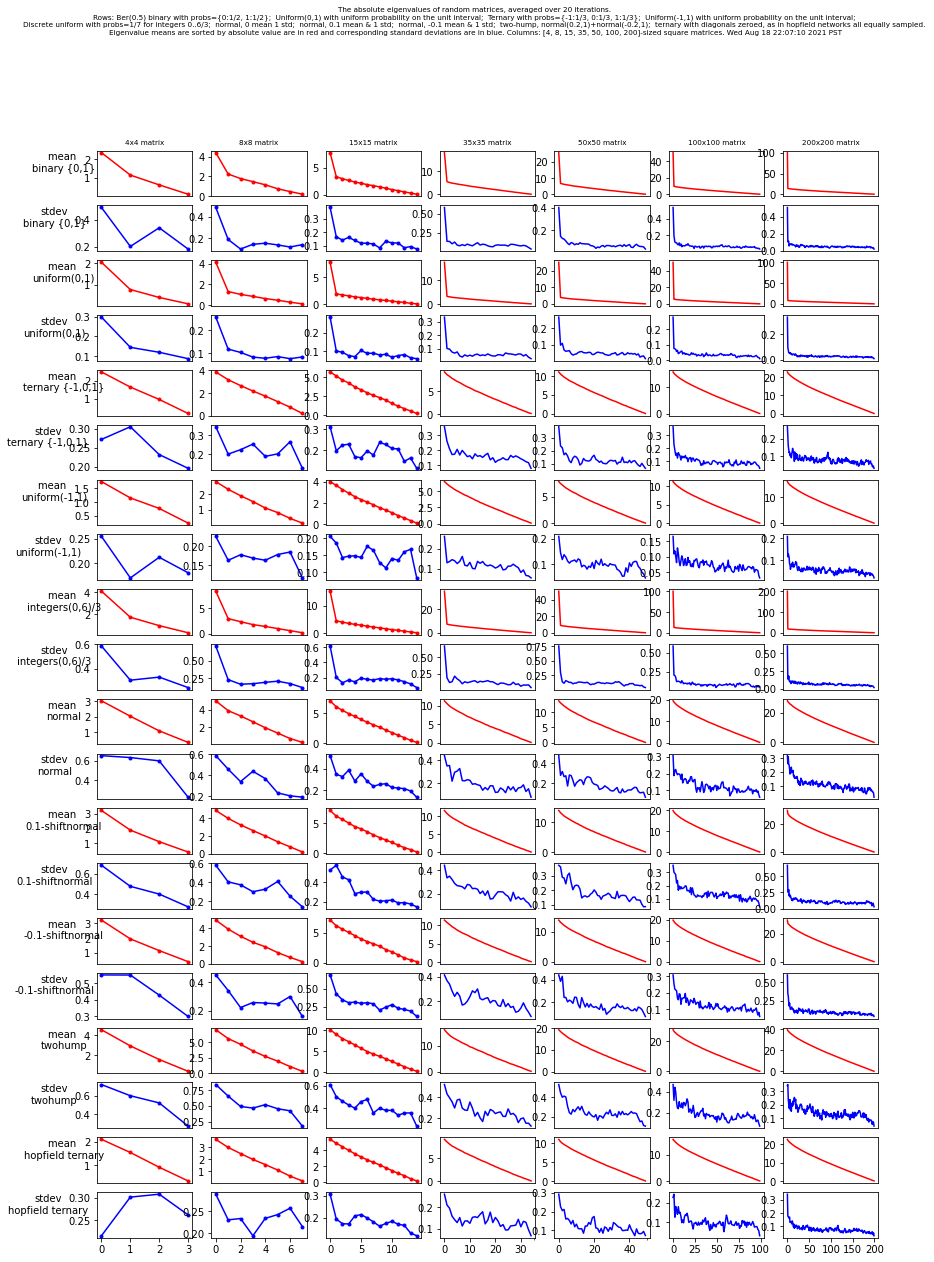

In [5]:
''' -------------------- Matplotlib setup, populate, and beautify -------------------- '''
plot_height = using_number_matrix_types * number_of_statistics 
fig, axs = plt.subplots(plot_height , len(square_matrix_sizes), figsize=(14, 20)) #figsize=(14, 7)) 
mpl.rcParams.update({'font.size': 6})
_s = "Eigenvalue means are sorted by absolute value are in red "+\
         "and corresponding standard deviations are in blue. "   \
        if number_of_statistics==2 else ''
full_infos = get_matrix_info_full() if not special_selections else get_matrix_info_full(special_selections)
fig.suptitle("The absolute eigenvalues of random matrices, averaged over "+str(Iterations)+\
        " iterations. \nRows: "+';  '.join(full_infos[:4])+ \
        "; \n"+';  '.join(full_infos[4:])+\
        " all equally sampled. \n"+_s+"Columns: "\
        +str(square_matrix_sizes)+"-sized square matrices. "+ctime()+" PST")
# subplot labels
for nth_matrix, MatrixSize in enumerate(square_matrix_sizes): 
    axs[0, nth_matrix].set_title(str(MatrixSize)+'x'+str(MatrixSize)+' matrix')
    axs[plot_height-1,nth_matrix].set_xticks([0,MatrixSize],[1,MatrixSize])
    for r in range(0,plot_height-1):
        axs[r,nth_matrix].set_xticks([],[])

brief_infos = get_matrix_info_brief() if not special_selections else get_matrix_info_brief(special_selections)
for distr_kind_iter, distribution_kind in enumerate( brief_infos ):
    axs[0+distr_kind_iter*number_of_statistics ,0].set_ylabel(\
                    'mean \n'+distribution_kind, rotation=0, labelpad=20)
    if number_of_statistics==2:
        axs[1+distr_kind_iter*number_of_statistics,0].set_ylabel(\
                    'stdev\n'+distribution_kind, rotation=0, labelpad=20)
        for nth_matrix in range(len(square_matrix_sizes)):
            continue
            axs[1+distr_kind_iter*number_of_statistics,nth_matrix].set_ylim(0,1)


            
            
            
            
''' -------------------- computations -------------------- '''
for nth_matrix, MatrixSize in enumerate(square_matrix_sizes):
    if special_selections: random_matrices = get_matrices(MatrixSize, special_selections)
    else: random_matrices = get_matrices(MatrixSize)
    for matr_ind, matr in enumerate(random_matrices):
        eigs = la.eigvals(matr)
#        eigs = np.multiply(eigs, eigs) # ie, singular values
#        eigs = abs(eigs) 
#        eigs = Round(eigs, decimals=Decimals)
#        eigs.sort(1)
#        eigs = np.fliplr(eigs)
#        means += [Round(eigs.mean(0))]
#        stdevs += [Round(np.std(eigs,0))]

        u,sings,vt = la.svd(matr)
        sings = Round(sings, decimals=Decimals)
        sings.sort(1)
        sings = np.fliplr(sings)
        means += [Round(sings.mean(0))]
        stdevs += [Round(np.std(sings,0))]


        marker='.' if MatrixSize<=25 else ''
        cur_ax = axs[0+number_of_statistics*matr_ind, nth_matrix]
        cur_ax.plot( means[-1], marker=marker, c='red')

        # numerical correction for orthonormal cases
#        print(cur_ax.get_ylim()[0]-cur_ax.get_ylim()[1], epsilon_for_ortho)
        if abs(cur_ax.get_ylim()[0]-cur_ax.get_ylim()[1])<epsilon_for_ortho:
                cur_ax.set_ylim((means[-1][-1]+means[-1][0])/2-epsilon_for_ortho, \
                                (means[-1][-1]+means[-1][0])/2+epsilon_for_ortho)
#                print( '--', means[-1], (means[-1][-1]+means[-1][0])/2-epsilon_for_ortho, \
#                        (means[-1][-1]+means[-1][0])/2+epsilon_for_ortho)

        if number_of_statistics==2:
            cur_ax=axs[1+number_of_statistics*matr_ind, nth_matrix]
            cur_ax.plot( stdevs[-1], marker=marker, c='blue')

        if Printing:
            print(eigs)
            print(eigs.shape)
            print(np.count_nonzero(eigs), MatrixSize*Iterations,\
                    np.count_nonzero(eigs)/float(MatrixSize*Iterations))

            print('mean: ', Round(eigs.mean(0)))
            print('stdev:', Round(np.std(eigs,0)))
            input()

plt.show()
plt.close()